# 🚀 Buybuddy Product Pipeline v2 - SAM3

**Pipeline Overview:**
```
API Login → Ürün Listesi → Video İndir → Gemini (Metadata) → SAM3 (Segment) → 518x518 Frames
```

**Outputs:**
- `frames/` → DINOv2 embedding için clean frame'ler
- `product.json` → Retailer catalog için rich metadata

---

## 📦 CELL 1: Library Installation
Sıfır environment için tüm dependency'ler kuruluyor.

In [19]:
# ============================================
# CELL 1: LIBRARY INSTALLATION
# İlk kez çalıştırıldığında tüm kütüphaneleri kurar
# ============================================

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("="*60)
print("LIBRARY INSTALLATION")
print("="*60)

# Core libraries
print("\n[1/4] Core libraries...")
install("torch")
install("torchvision")
install("numpy>=2.0.0")
print("  ✓ PyTorch, NumPy")

# API & Processing
print("\n[2/4] API & Processing...")
install("requests")
install("opencv-python")
install("pillow")
install("matplotlib")
install("tqdm")
print("  ✓ Requests, OpenCV, PIL, Matplotlib, tqdm")

# Gemini & HuggingFace
print("\n[3/4] Gemini & HuggingFace...")
install("google-generativeai")
install("huggingface_hub")
print("  ✓ Gemini, HuggingFace")

# SAM3 dependencies
print("\n[4/4] SAM3 dependencies...")
sam3_deps = ["einops", "decord", "timm", "iopath", "hydra-core", "omegaconf", "pycocotools"]
for dep in sam3_deps:
    install(dep)
print("  ✓ SAM3 dependencies")

# SAM3 from GitHub
print("\n[5/5] SAM3 from GitHub...")
subprocess.check_call([
    sys.executable, "-m", "pip", "install", "-q",
    "git+https://github.com/facebookresearch/sam3.git"
])
print("  ✓ SAM3")

print("\n" + "="*60)
print("✅ INSTALLATION COMPLETE!")
print("="*60)

LIBRARY INSTALLATION

[1/4] Core libraries...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.1 which is incompatible.
sam3 0.1.0 requires numpy<2,>=1.26, but you have numpy 2.4.1 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


  ✓ PyTorch, NumPy

[2/4] API & Processing...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sam3 0.1.0 requires numpy<2,>=1.26, but you have numpy 2.2.6 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


  ✓ Requests, OpenCV, PIL, Matplotlib, tqdm

[3/4] Gemini & HuggingFace...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


  ✓ Gemini, HuggingFace

[4/4] SAM3 dependencies...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


  ✓ SAM3 dependencies

[5/5] SAM3 from GitHub...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
label-studio 1.22.0 requires numpy<3.0.0,>=2.2.6, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


  ✓ SAM3

✅ INSTALLATION COMPLETE!


---
## 🔌 CELL 2: Imports & Environment Check

In [20]:
# ============================================
# CELL 2: IMPORTS & ENVIRONMENT CHECK
# ============================================

import os
import sys
import json
import time
import re
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from datetime import datetime

# Deep Learning
import torch
import numpy as np

# Image & Video
from PIL import Image
import cv2

# APIs
import requests
from huggingface_hub import login as hf_login

# Utilities
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# SAM3
from sam3.model_builder import build_sam3_video_predictor

print("="*60)
print("ENVIRONMENT CHECK")
print("="*60)
print(f"Python      : {sys.version.split()[0]}")
print(f"PyTorch     : {torch.__version__}")
print(f"NumPy       : {np.__version__}")
print(f"CUDA        : {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU         : {torch.cuda.get_device_name(0)}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Memory  : {gpu_mem:.1f} GB")

print("="*60)
print("✅ All imports successful!")

ENVIRONMENT CHECK
Python      : 3.11.10
PyTorch     : 2.9.1+cu128
NumPy       : 1.26.4
CUDA        : True
GPU         : NVIDIA GeForce RTX 4090
GPU Memory  : 25.3 GB
✅ All imports successful!


---
## ⚙️ CELL 3: Configuration
Tüm ayarlar bu cell'de. İhtiyaç olursa buradan değiştirin.

In [21]:
# ============================================
# CELL 3: CONFIGURATION
# Tüm ayarlar burada - ihtiyaca göre değiştir
# ============================================

class Config:
    # ===== API CREDENTIALS =====
    BUYBUDDY_API_BASE = "https://api-legacy.buybuddy.co/api/v1"
    BUYBUDDY_USERNAME = "your-username"
    BUYBUDDY_PASSWORD = "your-password"
    
    HUGGINGFACE_TOKEN = "your-huggingface-token"
    GEMINI_API_KEY = "your-gemini-api-key"
    
    # ===== MODEL SETTINGS =====
    GEMINI_MODEL = "gemini-2.0-flash-exp"
    
    # ===== PROCESSING SETTINGS =====
    TARGET_RESOLUTION = 518  # DINOv2 optimal
    MAX_FRAMES = None        # None = all frames
    FRAME_SAMPLE_RATE = 1    # 1 = every frame
    
    # ===== DEVICE =====
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # ===== PATHS =====
    OUTPUT_DIR = Path("./outputs")
    TEMP_DIR = Path("./temp")

# Create directories
Config.OUTPUT_DIR.mkdir(exist_ok=True)
Config.TEMP_DIR.mkdir(exist_ok=True)

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Device           : {Config.DEVICE}")
print(f"Target Size      : {Config.TARGET_RESOLUTION}x{Config.TARGET_RESOLUTION}")
print(f"Output Dir       : {Config.OUTPUT_DIR.absolute()}")
print("="*60)
print("✅ Config loaded!")

CONFIGURATION
Device           : cuda
Target Size      : 518x518
Output Dir       : /workspace/ai_pipeline/New Pipeline/outputs
✅ Config loaded!


---
## 🔐 CELL 4: API Authentication
Buybuddy API'ye login + HuggingFace authentication

In [22]:
# ============================================
# CELL 4: API AUTHENTICATION
# ============================================

print("="*60)
print("AUTHENTICATION")
print("="*60)

# ----- HUGGINGFACE -----
print("\n[1/3] HuggingFace Login...")
try:
    hf_login(token=Config.HUGGINGFACE_TOKEN, add_to_git_credential=False)
    print("✅ HuggingFace authenticated")
except Exception as e:
    print(f"⚠️ HuggingFace warning: {e}")

# ----- BUYBUDDY LOGIN -----
print("\n[2/3] Buybuddy Login...")
login_response = requests.post(
    f"{Config.BUYBUDDY_API_BASE}/user/sign_in",
    json={
        "user_name": Config.BUYBUDDY_USERNAME,
        "password": Config.BUYBUDDY_PASSWORD
    },
    headers={"Content-Type": "application/json"}
)

if login_response.status_code not in [200, 201]:
    print(f"❌ Login failed: {login_response.status_code}")
    raise Exception("Login failed")

login_data = login_response.json()
passphrase = login_data.get("passphrase")
print("✅ Login successful")

# ----- GET TOKEN -----
print("\n[3/3] Getting token...")
token_response = requests.post(
    f"{Config.BUYBUDDY_API_BASE}/user/sign_in/token",
    json={"passphrase": passphrase},
    headers={"Content-Type": "application/json"}
)

if token_response.status_code not in [200, 201]:
    print(f"❌ Token failed: {token_response.status_code}")
    raise Exception("Token request failed")

token_data = token_response.json()
auth_token = token_data.get("token")

API_HEADERS = {
    "Authorization": f"Bearer {auth_token}",
    "Content-Type": "application/json"
}

print("✅ Token received")
print("\n" + "="*60)
print("✅ AUTHENTICATION COMPLETE!")
print("="*60)

AUTHENTICATION

[1/3] HuggingFace Login...
✅ HuggingFace authenticated

[2/3] Buybuddy Login...
✅ Login successful

[3/3] Getting token...
✅ Token received

✅ AUTHENTICATION COMPLETE!


---
## 📋 CELL 5: Fetch Products from API
Ürün listesini çek ve incele

In [23]:
# ============================================
# CELL 5: FETCH PRODUCTS
# ============================================

print("="*60)
print("FETCHING PRODUCTS")
print("="*60)

products_response = requests.get(
    f"{Config.BUYBUDDY_API_BASE}/ai/product",
    headers=API_HEADERS
)

if products_response.status_code != 200:
    raise Exception(f"Failed: {products_response.status_code}")

raw_data = products_response.json()
products_list = raw_data.get("data", [])

print(f"✅ Total products: {len(products_list)}")

# ----- FIELD MAPPING -----
FIELD_MAPPING = {
    "barcode": "video.product.upc",
    "video_url": "video.media_url",
    "name": "video.product.name",
    "video_id": "video.id",
    "processed": "processed",
}

def get_field(product: dict, field: str) -> Any:
    """Get nested field from product dict"""
    key = FIELD_MAPPING.get(field, field)
    parts = key.split(".")
    value = product
    for part in parts:
        if isinstance(value, dict):
            value = value.get(part)
        else:
            return None
        if value is None:
            return None
    return value

# ----- PRODUCTS TABLE -----
print("\n" + "="*90)
print(f"{'#':<4} {'Proc':<5} {'Barcode':<15} {'Video ID':<10} {'Video URL':<50}")
print("-"*90)

products_with_video = []
unprocessed_products = []

for i, product in enumerate(products_list[:50]):
    barcode = get_field(product, 'barcode') or "N/A"
    video_url = get_field(product, 'video_url') or ""
    video_id = get_field(product, 'video_id') or ""
    processed = get_field(product, 'processed')
    
    proc_icon = "Y" if processed else "N"
    url_short = video_url[:48] + ".." if len(str(video_url)) > 50 else str(video_url)
    
    print(f"[{i:<2}] {proc_icon:<5} {str(barcode):<15} {str(video_id):<10} {url_short:<50}")
    
    if video_url:
        products_with_video.append(i)
        if not processed:
            unprocessed_products.append(i)

print("-"*90)
print(f"\nWith video: {len(products_with_video)} | Unprocessed: {len(unprocessed_products)}")

if unprocessed_products:
    print(f"💡 First unprocessed index: {unprocessed_products[0]}")

FETCHING PRODUCTS
✅ Total products: 4290

#    Proc  Barcode         Video ID   Video URL                                         
------------------------------------------------------------------------------------------
[0 ] N     934455001100    1367260    https://bb-item-images.s3.amazonaws.com/0c7093cb..
[1 ] N     049010557708    1367259    https://bb-item-images.s3.amazonaws.com/5986a730..
[2 ] N     049000557695    1367258    https://bb-item-images.s3.amazonaws.com/f939d01f..
[3 ] N     040400008626    1367257    https://bb-item-images.s3.amazonaws.com/6dd1159d..
[4 ] N     078000030914    1367256    https://bb-item-images.s3.amazonaws.com/cfea09a8..
[5 ] N     052000041538    1367255    https://bb-item-images.s3.amazonaws.com/f410b49c..
[6 ] N     036832024266    1367254    https://bb-item-images.s3.amazonaws.com/c2a3068a..
[7 ] N     036632024268    1367253    https://bb-item-images.s3.amazonaws.com/f0854563..
[8 ] N     044000047009    1367252    https://bb-item-images.s3.am

In [24]:
# ============================================
# CELL 6: SELECT PRODUCT
# ============================================

# 👇 Buradan index değiştir
SELECTED_INDEX = 5

selected_product = products_list[SELECTED_INDEX]

BARCODE = get_field(selected_product, 'barcode') or "unknown"
VIDEO_URL = get_field(selected_product, 'video_url')
VIDEO_ID = get_field(selected_product, 'video_id')

# Output paths
PRODUCT_OUTPUT_DIR = Config.OUTPUT_DIR / BARCODE
FRAMES_DIR = PRODUCT_OUTPUT_DIR / "frames"
PRODUCT_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

print("="*60)
print("SELECTED PRODUCT")
print("="*60)
print(f"Index      : {SELECTED_INDEX}")
print(f"Barcode    : {BARCODE}")
print(f"Video ID   : {VIDEO_ID}")
print(f"Video URL  : {VIDEO_URL}")
print(f"Output Dir : {PRODUCT_OUTPUT_DIR}")
print("="*60)

if not VIDEO_URL:
    print("\n❌ Bu ürünün videosu yok! SELECTED_INDEX değiştir.")
else:
    print("\n✅ Ready to process!")

SELECTED PRODUCT
Index      : 5
Barcode    : 052000041538
Video ID   : 1367255
Video URL  : https://bb-item-images.s3.amazonaws.com/f410b49c-6a35-4bcf-9424-6ce72b08f647.mp4
Output Dir : outputs/052000041538

✅ Ready to process!


VIDEO DOWNLOAD & FRAME EXTRACTION


  0%|          | 0.00/10.0M [00:00<?, ?B/s]


Video: 5.3s, 30fps, 160 frames


Extracting:   0%|          | 0/160 [00:00<?, ?it/s]


✅ Extracted 160 frames ((1920, 1080, 3))


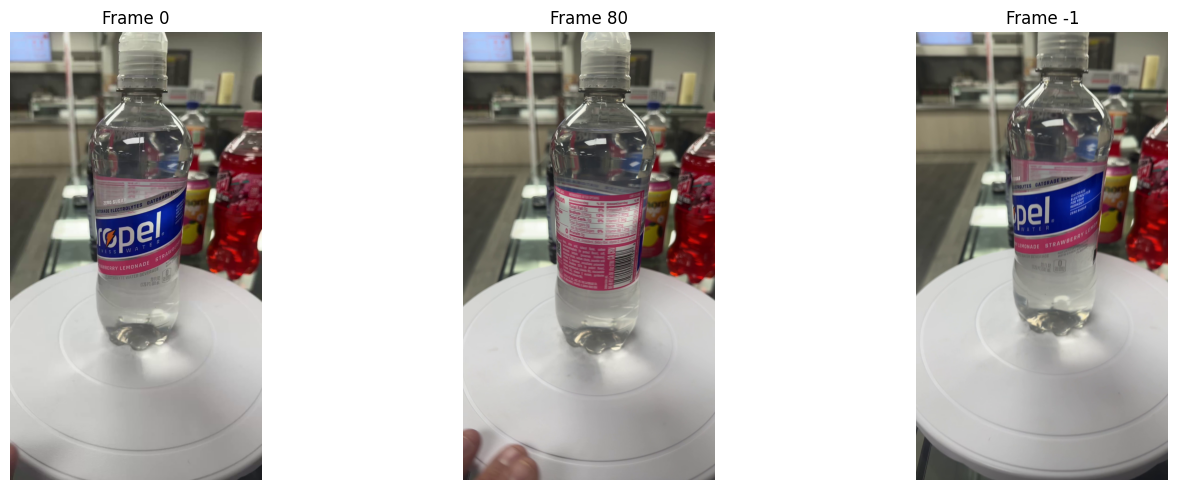

In [25]:
# ============================================
# CELL 7: DOWNLOAD VIDEO & EXTRACT FRAMES
# ============================================

def download_video(url: str, save_path: Path) -> Path:
    print(f"Downloading video...")
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total_size = int(response.headers.get('content-length', 0))
    
    with open(save_path, 'wb') as f, tqdm(total=total_size, unit='B', unit_scale=True) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
            pbar.update(len(chunk))
    return save_path

def get_video_info(video_path: Path) -> Dict:
    cap = cv2.VideoCapture(str(video_path))
    info = {
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'frame_count': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    }
    info['duration'] = info['frame_count'] / info['fps'] if info['fps'] > 0 else 0
    cap.release()
    return info

def extract_frames(video_path: Path, sample_rate: int = 1, max_frames: int = None) -> List[np.ndarray]:
    cap = cv2.VideoCapture(str(video_path))
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idx = 0
    
    with tqdm(total=total, desc="Extracting") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % sample_rate == 0:
                frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                if max_frames and len(frames) >= max_frames:
                    break
            frame_idx += 1
            pbar.update(1)
    cap.release()
    return frames

# Execute
print("="*60)
print("VIDEO DOWNLOAD & FRAME EXTRACTION")
print("="*60)

video_path = Config.TEMP_DIR / f"{BARCODE}_video.mp4"
download_video(VIDEO_URL, video_path)

video_info = get_video_info(video_path)
print(f"\nVideo: {video_info['duration']:.1f}s, {video_info['fps']:.0f}fps, {video_info['frame_count']} frames")

all_frames = extract_frames(video_path, Config.FRAME_SAMPLE_RATE, Config.MAX_FRAMES)
print(f"\n✅ Extracted {len(all_frames)} frames ({all_frames[0].shape})")

# Preview
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, idx in zip(axes, [0, len(all_frames)//2, -1]):
    ax.imshow(all_frames[idx])
    ax.set_title(f"Frame {idx}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# ============================================
# CELL 8: GEMINI - UPLOAD VIDEO
# ============================================

import google.generativeai as genai

print("="*60)
print("GEMINI - VIDEO UPLOAD")
print("="*60)

genai.configure(api_key=Config.GEMINI_API_KEY)

print("\nUploading video...")
video_file = genai.upload_file(path=str(video_path))
print(f"✅ Uploaded: {video_file.name}")

print("\nProcessing...")
while video_file.state.name == "PROCESSING":
    time.sleep(2)
    video_file = genai.get_file(video_file.name)
    print("  ...")

if video_file.state.name == "FAILED":
    raise ValueError("Video processing failed!")

print(f"✅ Video ready!")

GEMINI - VIDEO UPLOAD

Uploading video...
✅ Uploaded: files/ai5lfv7zzbbg

Processing...
  ...
✅ Video ready!


In [27]:
# ============================================
# CELL 9: GEMINI - METADATA EXTRACTION
# ============================================

print("="*60)
print("GEMINI - METADATA EXTRACTION")
print("="*60)

EXTRACTION_PROMPT = """You are an expert E-commerce Cataloging AI. Your task is to analyze the provided product video and generate a structured JSON output for a product directory.

### VIDEO PROCESSING STRATEGY
1. **Multi-Frame Analysis:** Scan the entire video. The front usually contains Brand/Name, while the back/sides contain Nutrition/Ingredients.
2. **Best Frame Selection:** Identify frames with the highest resolution text to minimize OCR errors.
3. **Visual Confirmation:** Only extract text that is visibly legible. Do not infer details based on shape alone.

### TEXT FORMATTING & NORMALIZATION RULES
1. **Spelling:** Maintain EXACT spelling as seen on the package.
2. **Capitalization:** Convert to **Title Case** for Brands and Product Names.
3. **Empty Values:** If not visible, return `null` for objects/numbers or `""` for strings.

### JSON OUTPUT SCHEMA
Return ONLY the following JSON object. No markdown, no conversational text.

{
  "brand_info": {
    "brand_name": "String: Main manufacturer. Title Case.",
    "sub_brand": "String: Product line or sub-brand. Empty string if none.",
    "manufacturer_country": "String: 'Made in X' if visible. Empty string if not."
  },
  "product_identity": {
    "product_name": "String: The specific item name. Title Case.",
    "variant_flavor": "String: Specific flavor/scent/color. Title Case.",
    "product_category": "Enum: [beverages, snacks, confectionery, dairy_refrigerated, pantry_food, frozen_food, bakery, health_personal_care, household_cleaning, electronics_accessories, pet_supplies, apparel, other]",
    "container_type": "Enum: [bottle, can, box, bag, pouch, jar, tube, packet, carton, cup, tray, blister_pack, wrapper, other]"
  },
  "specifications": {
    "net_quantity_text": "String: Exact weight/volume text.",
    "pack_configuration": {
        "type": "Enum: 'single_unit' or 'multipack'.",
        "item_count": "Integer: Total units."
    },
    "identifiers": {
      "barcode": "String: Digits only. Null if not visible.",
      "sku_model_code": "String: Visible model numbers. Null if not visible."
    }
  },
  "marketing_and_claims": {
    "claims_list": ["Array of Strings: Visible badges like 'Non-GMO', 'Keto Friendly'."],
    "marketing_description": "String: Brief descriptive blurb. Sentence case."
  },
  "nutrition_facts": {
    "serving_size": "String: e.g., '1 cup (240ml)'",
    "calories": "Number: e.g., 150",
    "total_fat": "String: e.g., '8g'",
    "protein": "String: e.g., '12g'",
    "carbohydrates": "String: e.g., '24g'",
    "sugar": "String: e.g., '10g'"
  },
  "visual_grounding": {
    "grounding_prompt": "String: '{Brand} {Product Name} {Container Type}' for object detection."
  },
  "extraction_metadata": {
    "visibility_score": "Number: 0-100 confidence based on text clarity.",
    "issues_detected": ["Array: e.g., 'glare_on_text', 'barcode_cutoff'"]
  }
}"""

print("\nExtracting metadata...")
model = genai.GenerativeModel(Config.GEMINI_MODEL)
response = model.generate_content([video_file, EXTRACTION_PROMPT])

# Parse response
def parse_gemini_response(text: str) -> dict:
    text = text.strip()
    text = re.sub(r'^```json\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^```\s*', '', text)
    text = re.sub(r'```\s*$', '', text)
    try:
        return json.loads(text.strip())
    except json.JSONDecodeError as e:
        print(f"⚠️ Parse error: {e}")
        return {"parse_error": str(e)}

product_metadata = parse_gemini_response(response.text)

# Add pipeline info
product_metadata['_pipeline'] = {
    'barcode': BARCODE,
    'video_id': VIDEO_ID,
    'timestamp': datetime.now().isoformat(),
    'model': Config.GEMINI_MODEL
}

print("\n✅ Metadata extracted!")
print("\n" + "-"*60)
print(json.dumps(product_metadata, indent=2, ensure_ascii=False))
print("-"*60)

# Grounding prompt
grounding_prompt = product_metadata.get('visual_grounding', {}).get('grounding_prompt', '')
print(f"\n🎯 Grounding prompt: '{grounding_prompt}'")

GEMINI - METADATA EXTRACTION

Extracting metadata...

✅ Metadata extracted!

------------------------------------------------------------
{
  "brand_info": {
    "brand_name": "Propel",
    "sub_brand": "Fitness Water",
    "manufacturer_country": ""
  },
  "product_identity": {
    "product_name": "Electrolyte Water Beverage",
    "variant_flavor": "Strawberry Lemonade",
    "product_category": "beverages",
    "container_type": "bottle"
  },
  "specifications": {
    "net_quantity_text": "23.7 Fl Oz (1.25 Pt) 699 Ml",
    "pack_configuration": {
      "type": "single_unit",
      "item_count": 1
    },
    "identifiers": {
      "barcode": "052000355742",
      "sku_model_code": null
    }
  },
  "marketing_and_claims": {
    "claims_list": [
      "Zero Sugar",
      "Gatorade Electrolytes"
    ],
    "marketing_description": ""
  },
  "nutrition_facts": {
    "serving_size": "1 Bottle (699 ml)",
    "calories": 0,
    "total_fat": "0g",
    "protein": "0g",
    "carbohydrates": "0g

In [28]:
# ============================================
# CELL 10: SAM3 - MODEL LOADING
# ============================================

print("="*60)
print("SAM3 - MODEL LOADING")
print("="*60)
print("\nİlk çalıştırmada model indirilecek (~2GB)...")

video_predictor = build_sam3_video_predictor()

print("\n✅ SAM3 Video Predictor loaded!")

if torch.cuda.is_available():
    mem = torch.cuda.memory_allocated() / 1e9
    print(f"GPU Memory used: {mem:.1f} GB")

INFO 2026-01-11 15:24:59,341 5502 sam3_video_predictor.py: 301: using the following GPU IDs: [0]
INFO 2026-01-11 15:24:59,343 5502 sam3_video_predictor.py: 317: 


	*** START loading model on all ranks ***


INFO 2026-01-11 15:24:59,344 5502 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- this could take a while ...


SAM3 - MODEL LOADING

İlk çalıştırmada model indirilecek (~2GB)...


INFO 2026-01-11 15:25:11,745 5502 sam3_video_base.py: 126: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-01-11 15:25:15,693 5502 sam3_video_predictor.py: 321: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-01-11 15:25:15,694 5502 sam3_video_predictor.py: 332: 


	*** DONE loading model on all ranks ***





✅ SAM3 Video Predictor loaded!
GPU Memory used: 9.0 GB


In [29]:
# ============================================
# CELL 11: SAM3 - VIDEO SEGMENTATION
# ============================================

print("="*60)
print("SAM3 - VIDEO SEGMENTATION")
print("="*60)

# Get grounding prompt
grounding_prompt = product_metadata.get('visual_grounding', {}).get('grounding_prompt', '')

if not grounding_prompt:
    brand = product_metadata.get('brand_info', {}).get('brand_name', '') or ''
    prod_name = product_metadata.get('product_identity', {}).get('product_name', '') or ''
    container = product_metadata.get('product_identity', {}).get('container_type', 'product') or 'product'
    grounding_prompt = f"{brand} {prod_name} {container}".strip() or "product"

print(f"Text prompt: '{grounding_prompt}'")

# Start session
print("\nStarting SAM3 session...")
response = video_predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=str(video_path),
    )
)
session_id = response["session_id"]
print(f"✅ Session started: {session_id}")

# Add text prompt
print(f"\nAdding text prompt...")
response = video_predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=0,
        text=grounding_prompt,
    )
)

print(f"✅ Prompt added!")
print(f"   Output keys: {response.keys()}")

# Get outputs
outputs = response.get("outputs", {})
print(f"\n✅ Segmentation complete!")

SAM3 - VIDEO SEGMENTATION
Text prompt: 'Propel Electrolyte Water Beverage Bottle'

Starting SAM3 session...


frame loading (OpenCV) [rank=0]: 100%|██████████| 160/160 [00:00<00:00, 250.00it/s]


✅ Session started: ca05a63f-b7ca-4a08-af5c-de562a16e9b2

Adding text prompt...
✅ Prompt added!
   Output keys: dict_keys(['frame_index', 'outputs'])

✅ Segmentation complete!


In [30]:
# ============================================
# CELL 12: SAM3 - PROPAGATE ALL FRAMES
# ============================================

print("="*60)
print("SAM3 - PROPAGATE THROUGH VIDEO")
print("="*60)

print(f"\nPropagating through {len(all_frames)} frames...")

# Forward propagation (frame 0'dan sonuna)
propagate_result = video_predictor.propagate_in_video(
    session_id=session_id,
    propagation_direction="forward",
    start_frame_idx=0,
    max_frame_num_to_track=len(all_frames)
)

print(f"Result type: {type(propagate_result)}")

# Collect results
all_frame_outputs = {}

if hasattr(propagate_result, '__iter__') and not isinstance(propagate_result, (dict, str)):
    print("Collecting frames...")
    for item in tqdm(propagate_result):
        if isinstance(item, dict):
            frame_idx = item.get('frame_index', len(all_frame_outputs))
            all_frame_outputs[frame_idx] = item.get('outputs', item)
        elif isinstance(item, tuple):
            frame_idx = item[0] if len(item) > 0 else len(all_frame_outputs)
            all_frame_outputs[frame_idx] = item[1] if len(item) > 1 else item
        else:
            all_frame_outputs[len(all_frame_outputs)] = item
elif isinstance(propagate_result, dict):
    all_frame_outputs = propagate_result
    
print(f"\n✅ Collected {len(all_frame_outputs)} frames")

# Sample check
if all_frame_outputs:
    sample_key = list(all_frame_outputs.keys())[0]
    sample = all_frame_outputs[sample_key]
    print(f"\nSample frame {sample_key}:")
    if isinstance(sample, dict):
        for k, v in sample.items():
            if hasattr(v, 'shape'):
                print(f"  {k}: {v.shape}")
            else:
                print(f"  {k}: {v}")

SAM3 - PROPAGATE THROUGH VIDEO

Propagating through 160 frames...
Result type: <class 'generator'>


0it [00:00, ?it/s]

propagate_in_video:   0%|          | 0/160 [00:00<?, ?it/s]


✅ Collected 160 frames

Sample frame 0:
  out_obj_ids: (1,)
  out_probs: (1,)
  out_boxes_xywh: (1, 4)
  out_binary_masks: (1, 1920, 1080)
  frame_stats: {'num_obj_tracked': 1, 'num_obj_dropped': 0}


POST-PROCESSING - CENTER & RESIZE TO 518x518

Processing 160 frames...


Processing:   0%|          | 0/160 [00:00<?, ?it/s]


✅ Processed 160 frames
   Output shape: (518, 518, 3)

Preview (original → mask → processed):


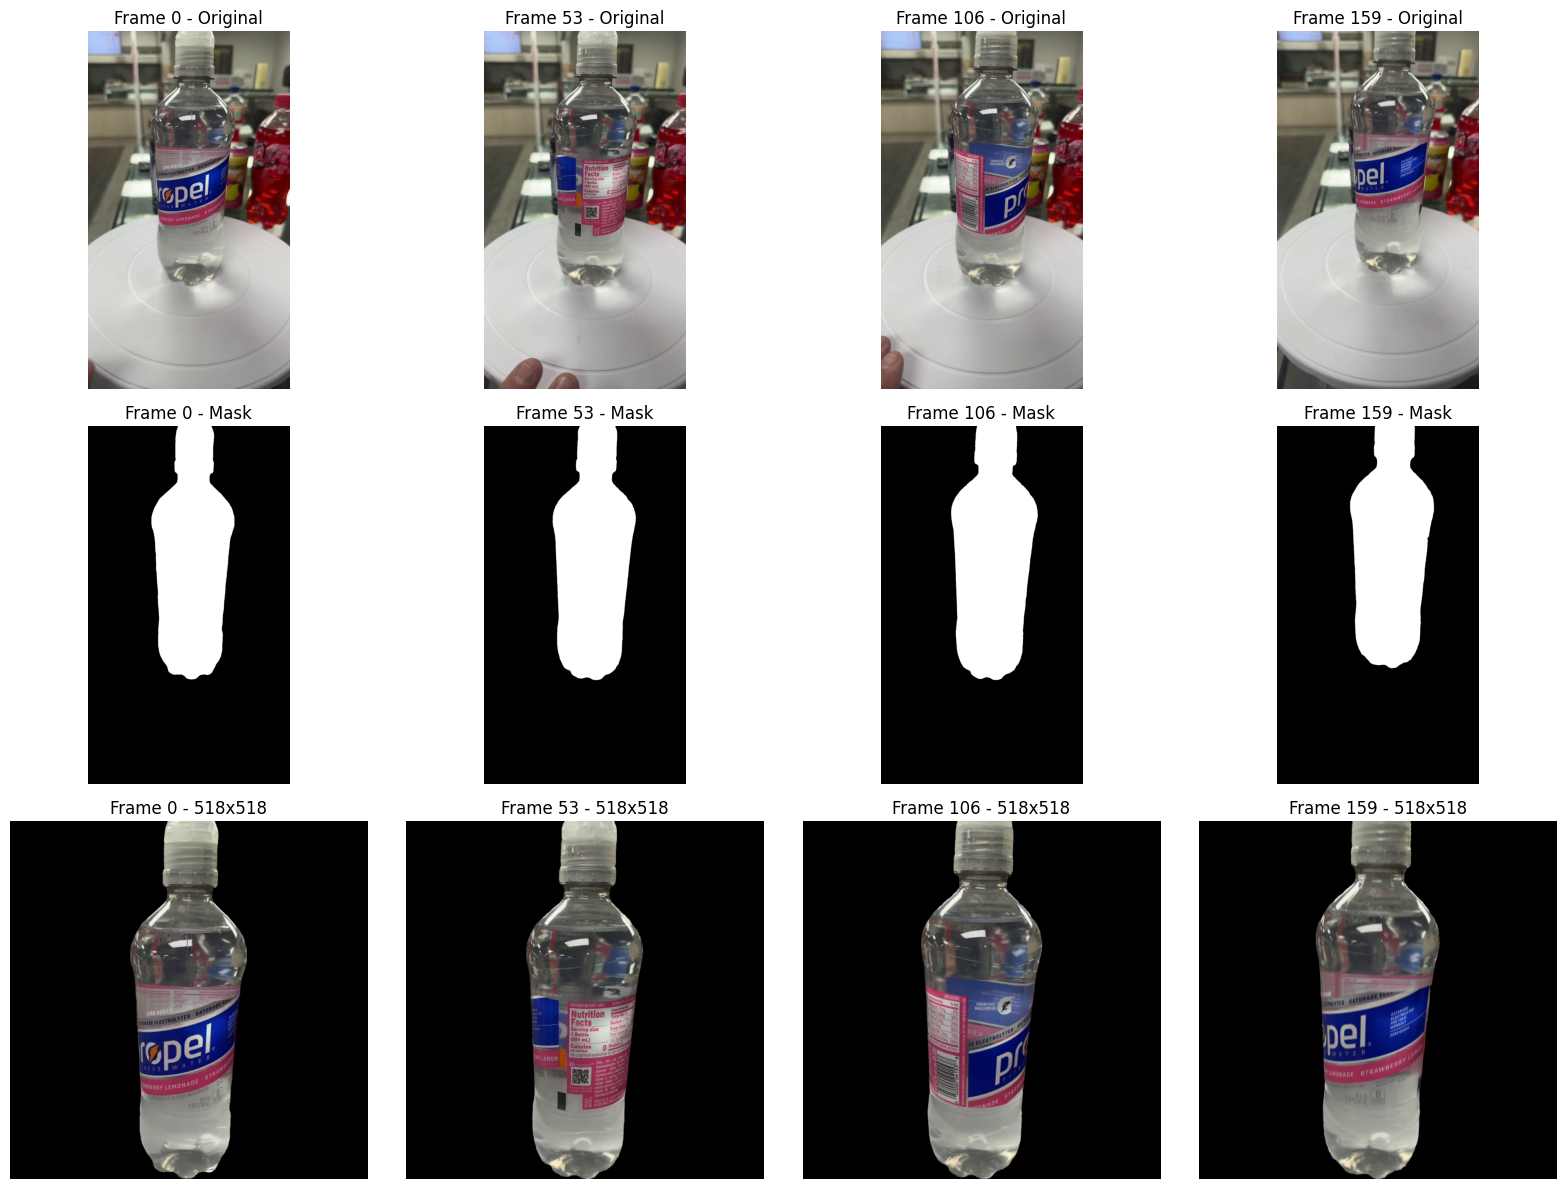

In [31]:
# ============================================
# CELL 13: POST-PROCESSING - CENTER & RESIZE
# ============================================

print("="*60)
print("POST-PROCESSING - CENTER & RESIZE TO 518x518")
print("="*60)

def process_frame_with_mask(frame: np.ndarray, mask: np.ndarray, target_size: int = 518) -> np.ndarray:
    """
    Mask kullanarak ürünü crop et ve siyah canvas üzerine ortala.
    
    Args:
        frame: RGB frame (H, W, 3)
        mask: Binary mask (H, W)
        target_size: Output size (default 518 for DINOv2)
    
    Returns:
        Centered product on black canvas (target_size, target_size, 3)
    """
    # Mask'ı frame boyutuna getir (gerekirse)
    if mask.shape != frame.shape[:2]:
        mask = cv2.resize(mask.astype(np.uint8), (frame.shape[1], frame.shape[0]))
        mask = mask.astype(bool)
    
    # Mask bounding box bul
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    
    if not rows.any() or not cols.any():
        # Mask boş, siyah canvas döndür
        return np.zeros((target_size, target_size, 3), dtype=np.uint8)
    
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    
    # Crop region
    cropped = frame[y_min:y_max+1, x_min:x_max+1].copy()
    cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]
    
    # Mask uygula (background siyah)
    cropped[~cropped_mask] = 0
    
    # Aspect ratio koruyarak resize
    h, w = cropped.shape[:2]
    scale = target_size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    
    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Siyah canvas üzerine ortala
    canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return canvas


# Process all frames
print(f"\nProcessing {len(all_frame_outputs)} frames...")

processed_frames = []

for frame_idx in tqdm(range(len(all_frames)), desc="Processing"):
    frame = all_frames[frame_idx]
    
    if frame_idx in all_frame_outputs:
        outputs = all_frame_outputs[frame_idx]
        mask = outputs['out_binary_masks'][0]  # İlk (ve tek) object
        
        # Mask'ı numpy'a çevir
        if hasattr(mask, 'cpu'):
            mask = mask.cpu().numpy()
        
        processed = process_frame_with_mask(frame, mask, Config.TARGET_RESOLUTION)
    else:
        # Mask yok, siyah frame
        processed = np.zeros((Config.TARGET_RESOLUTION, Config.TARGET_RESOLUTION, 3), dtype=np.uint8)
    
    processed_frames.append(processed)

print(f"\n✅ Processed {len(processed_frames)} frames")
print(f"   Output shape: {processed_frames[0].shape}")

# Preview
print("\nPreview (original → mask → processed):")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_indices = [0, len(all_frames)//3, 2*len(all_frames)//3, len(all_frames)-1]

for col, idx in enumerate(sample_indices):
    # Original
    axes[0, col].imshow(all_frames[idx])
    axes[0, col].set_title(f"Frame {idx} - Original")
    axes[0, col].axis('off')
    
    # Mask
    if idx in all_frame_outputs:
        mask = all_frame_outputs[idx]['out_binary_masks'][0]
        if hasattr(mask, 'cpu'):
            mask = mask.cpu().numpy()
        axes[1, col].imshow(mask, cmap='gray')
    axes[1, col].set_title(f"Frame {idx} - Mask")
    axes[1, col].axis('off')
    
    # Processed
    axes[2, col].imshow(processed_frames[idx])
    axes[2, col].set_title(f"Frame {idx} - 518x518")
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()

In [32]:
# ============================================
# CELL 14: SAVE OUTPUTS
# ============================================

print("="*60)
print("SAVING OUTPUTS")
print("="*60)

# Save frames
print(f"\nSaving {len(processed_frames)} frames to {FRAMES_DIR}...")

for i, frame in enumerate(tqdm(processed_frames, desc="Saving frames")):
    frame_path = FRAMES_DIR / f"frame_{i:04d}.png"
    Image.fromarray(frame).save(frame_path)

print(f"✅ Frames saved to {FRAMES_DIR}")

# Add frame info to metadata
product_metadata['_pipeline']['num_frames'] = len(processed_frames)
product_metadata['_pipeline']['frame_resolution'] = Config.TARGET_RESOLUTION

# Save product.json
json_path = PRODUCT_OUTPUT_DIR / "product.json"
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(product_metadata, indent=2, ensure_ascii=False, fp=f)

print(f"✅ Metadata saved to {json_path}")

# Summary
print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)
print(f"\nOutput directory: {PRODUCT_OUTPUT_DIR}")
print(f"├── frames/")
print(f"│   └── {len(processed_frames)} PNG files ({Config.TARGET_RESOLUTION}x{Config.TARGET_RESOLUTION})")
print(f"└── product.json")
print(f"\nProduct: {product_metadata.get('brand_info', {}).get('brand_name', '')} {product_metadata.get('product_identity', {}).get('product_name', '')}")
print(f"Barcode: {BARCODE}")

# Cleanup temp
print(f"\nCleaning up temp files...")
if video_path.exists():
    video_path.unlink()
    print(f"  Deleted: {video_path.name}")

# Close session
video_predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)
print("  Closed SAM3 session")

print("\n✅ Done!")

SAVING OUTPUTS

Saving 160 frames to outputs/052000041538/frames...


Saving frames:   0%|          | 0/160 [00:00<?, ?it/s]

✅ Frames saved to outputs/052000041538/frames
✅ Metadata saved to outputs/052000041538/product.json

PIPELINE COMPLETE!

Output directory: outputs/052000041538
├── frames/
│   └── 160 PNG files (518x518)
└── product.json

Product: Propel Electrolyte Water Beverage
Barcode: 052000041538

Cleaning up temp files...
  Deleted: 052000041538_video.mp4


INFO 2026-01-11 15:26:00,403 5502 sam3_video_predictor.py: 252: removed session ca05a63f-b7ca-4a08-af5c-de562a16e9b2; live sessions: [], GPU memory: 10235 MiB used and 14192 MiB reserved (max over time: 13789 MiB used and 14192 MiB reserved)


  Closed SAM3 session

✅ Done!
